In [ ]:

!pip install nltk --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk, string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier

nltk.download("stopwords")

def print_cm_acc(y_true, y_pred, title=""):
    print(f"\n=== {title} ===")
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    print("Accuracy:", acc)




def manual_adaboost(X_train, y_train, X_test, y_test, T=15):
    y_train = np.array(y_train)
    n = len(y_train)
    w = np.ones(n)/n

    stumps = []
    alphas = []
    errors = []

    for t in range(1, T+1):
        stump = DecisionTreeClassifier(max_depth=1)
        stump.fit(X_train, y_train, sample_weight=w)
        pred = stump.predict(X_train)

        mis = (pred != y_train)
        err = np.sum(w[mis])
        err = np.clip(err, 1e-10, 1-1e-10)

        alpha = 0.5 * np.log((1-err)/err)

        print(f"\n--- Iteration {t} ---")
        print("Misclassified index:", np.where(mis)[0][:10], "...")
        print("Error:", err)
        print("Alpha:", alpha)

        w = w * np.exp(np.where(mis, alpha, -alpha))
        w = w / w.sum()

        stumps.append(stump)
        alphas.append(alpha)
        errors.append(err)

    def predict_boost(X):
        preds = np.array([clf.predict(X) for clf in stumps])
        preds = 2*preds - 1
        agg = np.dot(alphas, preds)
        return (agg > 0).astype(int)

    y_train_pred = predict_boost(X_train)
    y_test_pred  = predict_boost(X_test)

    print_cm_acc(y_train, y_train_pred, "Manual Boost Train")
    print_cm_acc(y_test,  y_test_pred,  "Manual Boost Test")

    return errors, alphas


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



=== BASELINE (STUMP) ===
Accuracy: 0.5333333333333333
Confusion Matrix:
 [[32  0  0  0  0]
 [11  0  0  0  0]
 [ 7  0  0  0  0]
 [ 7  0  0  0  0]
 [ 3  0  0  0  0]]

=== GRID SEARCH RESULTS ===
lr=0.1, n=5, acc=0.5333333333333333
lr=0.1, n=10, acc=0.55
lr=0.1, n=25, acc=0.6
lr=0.1, n=50, acc=0.6166666666666667
lr=0.1, n=100, acc=0.6166666666666667
lr=0.5, n=5, acc=0.5833333333333334
lr=0.5, n=10, acc=0.6
lr=0.5, n=25, acc=0.6
lr=0.5, n=50, acc=0.6166666666666667
lr=0.5, n=100, acc=0.6333333333333333
lr=1.0, n=5, acc=0.5833333333333334
lr=1.0, n=10, acc=0.6333333333333333
lr=1.0, n=25, acc=0.5833333333333334
lr=1.0, n=50, acc=0.6
lr=1.0, n=100, acc=0.6166666666666667

🔥 BEST CONFIGURATION 🔥
Learning Rate: 0.5
Estimators: 100
Accuracy: 0.6333333333333333

=== FINAL MODEL RESULTS ===
Final Accuracy: 0.6333333333333333
Final Confusion Matrix:
 [[29  2  0  0  1]
 [ 5  3  1  2  0]
 [ 0  5  1  1  0]
 [ 0  0  2  5  0]
 [ 0  1  0  2  0]]


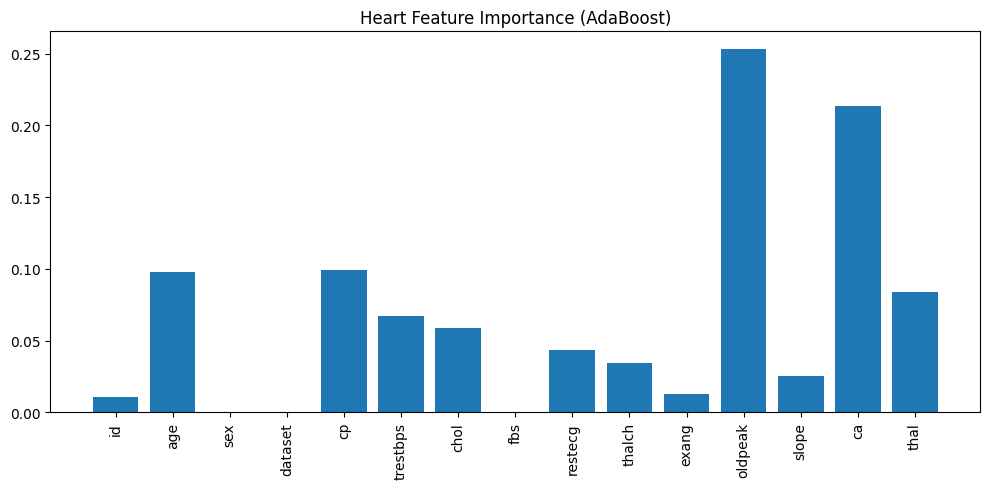

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Load your file
df = pd.read_csv("heart.csv")

df = df.dropna().reset_index(drop=True)

cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].astype("category").apply(lambda x: x.cat.codes)

X = df.drop("num", axis=1)
y = df["num"]

Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(Xtr, ytr)

print("\n=== BASELINE (STUMP) ===")
print("Accuracy:", accuracy_score(yte, stump.predict(Xte)))
print("Confusion Matrix:\n", confusion_matrix(yte, stump.predict(Xte)))


n_list = [5, 10, 25, 50, 100]
lr_list = [0.1, 0.5, 1.0]

best_acc = -1
best_lr = None
best_n = None

print("\n=== GRID SEARCH RESULTS ===")
for lr in lr_list:
    for n in n_list:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr
        )
        ada.fit(Xtr, ytr)
        acc = accuracy_score(yte, ada.predict(Xte))
        print(f"lr={lr}, n={n}, acc={acc}")

        if acc > best_acc:
            best_acc = acc
            best_lr = lr
            best_n = n

print("\n🔥 BEST CONFIGURATION 🔥")
print("Learning Rate:", best_lr)
print("Estimators:", best_n)
print("Accuracy:", best_acc)


ada_best = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr
)
ada_best.fit(Xtr, ytr)

y_pred_best = ada_best.predict(Xte)

print("\n=== FINAL MODEL RESULTS ===")
print("Final Accuracy:", accuracy_score(yte, y_pred_best))
print("Final Confusion Matrix:\n", confusion_matrix(yte, y_pred_best))


importances = ada_best.feature_importances_

plt.figure(figsize=(10,5))
plt.bar(X.columns, importances)
plt.xticks(rotation=90)
plt.title("Heart Feature Importance (AdaBoost)")
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
df = pd.read_csv("heart.csv")
df.head()
df.columns


Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')